Week 12 assignment


정주호

2019312072

In [ ]:
import pandas as pd
import numpy as np
import math
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
random_seed = 2020

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import xgboost as xgb

In [ ]:
! pip install soynlp

     |████████████████████████████████| 419kB 31.4MB/s 


In [ ]:
! pip install konlpy  
! bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

     |████████████████████████████████| 19.4MB 47.5MB/s 
     |████████████████████████████████| 460kB 31.1MB/s 
     |████████████████████████████████| 92kB 9.9MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Installing automake (A dependency for mecab-ko)
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/

## Case 1: Text Sentiment Classification
-  inputs: 네이버 영화 평점
-  ouput: 긍정(1)  or 부정(0)

## Load dataset

- 데이터셋 불러오기

In [ ]:
#movie_review = pd.read_csv('/content/drive/MyDrive/dsail/skku/2021-1/[조교]datamining/week12_ml/dataset/ratings.txt', delimiter='\t', index_col='id').reset_index(drop=True).dropna()
movie_review = pd.read_csv('imdb_dataset.txt', delimiter='\t', compression='zip').reset_index(drop=True).dropna()
movie_review.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [ ]:
movie_review.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


- 긍정 리뷰와 부정 리뷰 비율 확인(다를 경우, 클래스 불균형 문제 발생)

In [ ]:
pd.DataFrame(movie_review['sentiment'].value_counts(normalize=True))

,sentiment
negative,0.5
positive,0.5


## Split dataset

In [ ]:
data = movie_review['review'].values.tolist()
target = movie_review['sentiment'].values.tolist()

In [ ]:
print(data[0], target[0])

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fac

- 분류 모델을 위해 데이터셋을 data, target으로 나누기
- `from sklearn.model_selection import train_test_split`
    - test_size(float): 전체에서 테스트셋 비율
    - random_state(int): 호출할 때 마다 동일한 학습/테스트용 데이터 세트를 생성하기 위한 난수 값
    - shuffle(boolean): 데이터를 분리하기 위해 데이터를 섞을 건 지 말건 지?

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, 
                                                    test_size=0.3, 
                                                    random_state=random_seed)

## Data preprocessing

- 한글 전처리

```
from soynlp.normalizer import *

emoticon_normalize('ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ쿠ㅜㅜㅜㅜㅜㅜ', num_repeats=3)
# 'ㅋㅋㅋㅜㅜㅜ'

repeat_normalize('와하하하하하하하하하핫', num_repeats=2)
# '와하하핫'

only_hangle('가나다ㅏㅑㅓㅋㅋ쿠ㅜㅜㅜabcd123!!아핫')
# '가나다ㅏㅑㅓㅋㅋ쿠ㅜㅜㅜ 아핫'

only_hangle_number('가나다ㅏㅑㅓㅋㅋ쿠ㅜㅜㅜabcd123!!아핫')
# '가나다ㅏㅑㅓㅋㅋ쿠ㅜㅜㅜ 123 아핫'

only_text('가나다ㅏㅑㅓㅋㅋ쿠ㅜㅜㅜabcd123!!아핫')
# '가나다ㅏㅑㅓㅋㅋ쿠ㅜㅜㅜabcd123!!아핫'
```



In [ ]:
from soynlp.normalizer import *

In [ ]:
! pip install contractions
import re
import contractions

     |████████████████████████████████| 286kB 29.0MB/s 
     |████████████████████████████████| 327kB 37.5MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85399 sha256=01fcad5bbaaa0b3ea9368077f13b55824b9964e40974dc6551a45ba4ff6a8c92
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick


In [ ]:
def my_preprocessor(text):
    text = contractions.fix(text) #he's -> he is
    text = re.sub('<br />'," ",text)  
    text = re.sub('https?:/\/\S+', ' ', text) # remove urls
    text = re.sub('[0-9]+', ' ', text) # remove numbers
    text = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\…》]+', ' ', text) # remove all symbols and punctuation except for . , ! and ?
    text = re.sub("'"," ", text)
    text = re.sub('\s+', ' ', text) # 중복 띄어쓰기 삭제

    text = text.lower() # 소문자
    return text.strip()

In [ ]:
my_preprocessor(data[0])

'one of the other reviewers has mentioned that after watching just oz episode you will be hooked they are right as this is exactly what happened with me the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the word it is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda them city is home to many aryans muslims gangstas latinos christians italians irish and more so scuffles death stares dodgy dealings and shady agreements are never far away i would say the main appeal of the show is due to the fact that it goes where other shows would not dare forget pre

- 토크나이징:  문장을 최소단위(여기에서는 단어)로 쪼개 줌

In [ ]:
#from konlpy.tag import Mecab
#mecab = Mecab()

In [ ]:
#mecab.morphs(data[0])

['어릴', '때', '보', '고', '지금', '다시', '봐도', '재밌', '어요', 'ㅋㅋ']

In [ ]:
#mecab.nouns(data[0])

['때']

In [ ]:
#mecab.pos(data[0])

[('어릴', 'VA+ETM'),
 ('때', 'NNG'),
 ('보', 'VV'),
 ('고', 'EC'),
 ('지금', 'MAG'),
 ('다시', 'MAG'),
 ('봐도', 'VV+EC'),
 ('재밌', 'VA'),
 ('어요', 'EF'),
 ('ㅋㅋ', 'IC')]

In [ ]:
#def my_tokenizer(text):
#    return mecab.morphs(text)

**택스트가 영어기 때문에 영어 토큰화 실행**

In [ ]:
#영어 토큰화

In [ ]:
import spacy
import en_core_web_sm
from spacy.lang.en import English
from tqdm import tqdm

# https://spacy.io/usage

In [ ]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner']) 
spacy_stopwords=spacy.lang.en.stop_words.STOP_WORDS

In [ ]:
temp = nlp(data[0])
temp

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fac

In [ ]:
temp[2]

the

In [ ]:
temp[10].lemma_

'just'

In [ ]:
def my_tokenizer(sentence):
    text=nlp(sentence)
    temp=[token.lemma_ for token in text if token.lemma_ not in ['-PRON-'] + list(spacy_stopwords)]
    
    return temp
#    return " ".join(temp)

In [ ]:
my_tokenizer(my_preprocessor(data[0]))

['reviewer',
 'mention',
 'watch',
 'oz',
 'episode',
 'hook',
 'right',
 'exactly',
 'happen',
 'thing',
 'strike',
 'oz',
 'brutality',
 'unflinche',
 'scene',
 'violence',
 'set',
 'right',
 'word',
 'trust',
 'faint',
 'hearted',
 'timid',
 'pull',
 'punch',
 'regard',
 'drug',
 'sex',
 'violence',
 'hardcore',
 'classic',
 'use',
 'word',
 'oz',
 'nickname',
 'oswald',
 'maximum',
 'security',
 'state',
 'penitentary',
 'focus',
 'mainly',
 'emerald',
 'city',
 'experimental',
 'section',
 'prison',
 'cell',
 'glass',
 'face',
 'inward',
 'privacy',
 'high',
 'agenda',
 'city',
 'home',
 'aryan',
 'muslims',
 'gangstas',
 'latinos',
 'christians',
 'italian',
 'irish',
 'scuffle',
 'death',
 'stare',
 'dodgy',
 'dealing',
 'shady',
 'agreement',
 'far',
 'away',
 'main',
 'appeal',
 'fact',
 'dare',
 'forget',
 'pretty',
 'picture',
 'paint',
 'mainstream',
 'audience',
 'forget',
 'charm',
 'forget',
 'romance',
 'oz',
 'mess',
 'episode',
 'strike',
 'nasty',
 'surreal',
 'ready

## Word Vectorizer
-  머신러닝 알고리즘은 일반적으로 숫자형 피처를 인풋값으로 받기때문에,  텍스트,  이미지 등 비정형  데이터는  데이터를 벡터값으로 변환해주는 과정이 필요함.  텍스트  데이터를 벡터화하는 방법 중 하나가 BOW.
- Bag of Words (BOW)  모델은 문서가 가지는 모든 단어를 문맥이나 순서를 무시하고,,  일괄적으로 단어에 대해 빈도 값을 부여해 피처를 추출하는 모델.
- BOW에는 일반적으로 두 종류가 존재
    -  카운트 기반 벡터화:  `from sklearn.feature_extraction.text import CountVectorizer`
        -  단어를 각  문서에서 해당 단어가 나타나는 횟수로 벡터화
    -  TF (Term Frequency - Inverse Document Frequency) 기반 벡터화  `from sklearn.feature_extraction.text import TfidfVectorizer`
        -  단어를 TF-IDF (개별 문서에 자주 나타나는 단어에 높은 가중치를 주되,,  전반적으로 자주 나타나는 단어에는 패널티를 부여) 수치로 벡터화

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Counter Vectorization으로 피처 벡터화 수행
cnt_vect = CountVectorizer(lowercase=True, preprocessor = my_preprocessor,  tokenizer = my_tokenizer, min_df=5, max_features=1600)
cnt_vect.fit(X_train)

X_train_cnt_vect = cnt_vect.transform(X_train)

#  학습 데이터로 fit()된 Vectorizer를 이용해 테스트 데이터를 피처 벡터화 변환 수행
X_test_cnt_vect = cnt_vect.transform(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [ ]:
print(X_train_cnt_vect.shape)

(35000, 1600)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# X_train
tfidf_vect = TfidfVectorizer(lowercase=False, preprocessor = my_preprocessor,  tokenizer = my_tokenizer, min_df=5, max_features=1600)

tfidf_vect.fit(X_train)
X_train_tfidf_vect = tfidf_vect.transform(X_train)

# X_test
X_test_tfidf_vect = tfidf_vect.transform(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


### [+] 특성값이 높은 단어 확인

In [ ]:
max_value = X_train_cnt_vect.max(axis=0).toarray().ravel()
sorted_value = max_value.argsort()
feature_names = np.array(cnt_vect.get_feature_names())
feature_names[sorted_value[-100:]]

array(['good', 'horror', 'demon', 'hotel', 'brian', 'identity', 'bear',
       'david', 'rape', 'radio', 'follow', 'vs', 'dr', 'rock',
       'character', 'role', 'book', 'pretty', 'pilot', 'julie', 'bad',
       'water', 'high', 'michael', 'machine', 'computer', 'wave', 'boss',
       'davis', 'woman', 'bed', 'mask', 'story', 'ray', 'gay', 'buddy',
       ';', 'flick', 'life', 'stewart', 'novel', 'song', 'football',
       'robert', 'danny', 'war', 'monkey', 'post', 'chaplin', 'ben',
       '\x96', 'segment', 'ann', 'soldier', 'jackson', 'force', 'season',
       'love', 'kelly', 'harry', 'dream', 'game', 'mary', 'time',
       'series', 'batman', 'beach', 'james', 'howard', 'master', 'joke',
       'joe', 'child', 'stop', 'mad', 'steve', 'heart', 'great',
       'charlie', 'f', 'joan', 'jane', 'jeff', 'x', 'jason', 'bond',
       'snake', 'rating', 'car', 'guy', 'sam', 'zombie', 'movie', 'match',
       'like', 'rob', 'tony', 'film', '_', 's'], dtype='<U14')

In [ ]:
max_value = X_train_tfidf_vect.max(axis=0).toarray().ravel()
sorted_value = max_value.argsort()
feature_names = np.array(tfidf_vect.get_feature_names())
feature_names[sorted_value[-100:]]

array(['channel', 'camp', 'mystery', 'allen', 'vampire', 'bed', 'andy',
       'eddie', ';', 'nightmare', 'hand', 'teach', 'shakespeare',
       'taylor', 'gang', 'vs', 'terrible', 'annoy', 'horse', 'arthur',
       'rape', 'disney', 'jane', 'wow', 'view', 'season', 'joe', 'bad',
       'rob', 'identity', 'double', 'henry', 'computer', 'hot', 'grace',
       'werewolf', 'talk', 'sex', 'monkey', 'football', 'al', 'tired',
       'smith', 'chaplin', 'study', 'ben', 'gary', 'band', 'beach',
       'shoot', 'stewart', 'bob', 'kelly', 'christopher', 'australian',
       'opera', 'jesus', 'episode', 'pack', 'page', 'match', 'stupid',
       'suck', 'jason', 'bond', 'sam', 'awful', 'd', 'version', 'college',
       'p', 'german', 'mary', 'ann', 'cartoon', 'check', 'program', 'f',
       'ray', 'beautifully', 'batman', 'mike', 'jeff', 'master', 'buddy',
       'jerry', 'zombie', '\x96', 'little', 'snake', 'bruce', 'cat',
       'joan', 'game', 'rating', 'joke', 'horrible', 'steve', 'demon',
  

## Model Selection
- 여러가지 분류 알고리즘을 defalut hyperparameter로 돌리면서, 사용할 model을 탐색
![Choosing the right estimator](https://scikit-learn.org/stable/_static/ml_map.png)
    - Sklearn 각 모델에 대한 간단한 요약 (Reference: 세라 가이도 & 안드레아스 뮐러 저(2017), 박해선 역, 파이썬 라이브러리를 활용한 머신러닝, 한빛미디어.)
        - KNN: 작은 데이터셋일 경우, 기본 모델로서 좋고 설명하기 쉬움
        - Linear Model: 첫번째로 시도할 알고리즘, 대용량 데이터셋 가능. 고차원 데이터에 가능
        - 나이브 베이즈(Naive Bayesian): 분류만 가능. 선형 모델보다 훨씬 빠름. 대용량 데이터셋과 고차원 데이터에 가능. 선형 모델보다 덜 정확함.
        - Decision Tree: 매우 빠름. 데이터 스케일 조정이 필요 없음. 시각화하기 좋고 설명하기 쉬움.
        - Random Forest: 결정 트리 하나보다 거의 항상 좋은 성능을 냄. 매우 안정적이고 강력함. 데이터 스케일 조정 필요 없음. 고차원 희소 데이터에서는 잘 안 맞음.
        - Gradient Boosting Decision Tree: 랜덤 포레스트보다 더 성능이 좋음. 랜덤 포레스트 보다 학습은 느리나 예측은 빠르고 메모리를 조금 사용. 랜덤 포레스트보다 매개변수 튜닝이 많이 필요함.
        - 서포트 벡터 머신: 비슷한 의미 특성으로 이뤄진 중간 규모 데이터셋에 잘 맞음. 데이터 스케일 조정 필요. 매개 변수에 민감.
        - 신경망: 특별히 대용량 데이터셋에서 매우 복잡한 모델을 만들 수 있음. 매개변수 선택과 데이터 스케일에 민감. 큰 모델은 학습이 오래걸림.
        ---
        - AdaBoostClassifier (Adaptive Boosting)
    - [+] (Sklearn 제공 X) 트리 기반의 앙상블 기법 알고리즘 
        - XGBoost (Extreme Gradient Boosting)
        - LightGBM (Light Gradient Boosting Method)

## Evaluation

- Precision(정밀도): TP / (TP+FP) ~ 예측을 Positive로 한 대상 중에 예측과 실제값이 Positive로 일치한 데이터의 비율
- Recall(재현율): TP / (TP + FN) ~ 실제값이 Positive로 한 대상 중에 예측과 실제값이 Positive로 일치한 비율
- F1-score: trade-off between precision and recall
- AUC: Area Under the ROC (TPR vs. RPF) Curve, 
- 모두 sklearn에 구현되어 있음

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [ ]:
def evaluation_report(y_test, pred, is_return=True):
        from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
        acc = accuracy_score(y_test, pred) 
        pre=precision_score(y_test, pred)
        recall = recall_score(y_test, pred)
        f1 = f1_score(y_test, pred)
        auc = roc_auc_score(y_test, pred)
        for name, value in zip(['accuracy_score', 'precision_score', 'recall_score', 'f1_score', 'roc_auc_score'], [acc, pre, recall, f1, auc]):
            print('{name} = {value:.2f}'.format(name=name, value=value), end='\t')

# Example 1: Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter = 200, n_jobs=-1)
lr_clf.fit(X_train_cnt_vect, y_train)
pred = lr_clf.predict(X_test_cnt_vect)

In [ ]:
pred

array(['positive', 'positive', 'negative', ..., 'positive', 'positive',
       'positive'], dtype='<U8')

In [ ]:
y_test[:3]

['positive', 'positive', 'negative']

In [ ]:
recall_average = recall_score(y_test, pred, average="binary", pos_label="negative")

In [ ]:
recall_average

0.863928284720364

In [ ]:
accuracy_score(y_test, pred) 

0.8688666666666667

In [ ]:
precision_score(y_test, pred, average="binary", pos_label="negative")

0.8717429458620224

In [ ]:
recall_score(y_test, pred, average="binary", pos_label="negative")

0.863928284720364

In [ ]:
f1_score(y_test, pred, average="binary", pos_label="negative")

0.8678180229823265

In [ ]:
roc_auc_score(y_test, pred)

**결과값이 positive, negative으로 되어 있기 때문에 비교가 안되어서 evaluation_report함수 재정의**

In [ ]:
#array가 positive, negative으로 되어 있기 때문에 비교가 안되어서 evaluation_report함수 재정의

In [ ]:
def evaluation_report(y_test, pred, is_return=True):
        from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
        acc = accuracy_score(y_test, pred) 
        pre=precision_score(y_test, pred, average="binary", pos_label="negative")
        recall = recall_score(y_test, pred, average="binary", pos_label="negative")
        f1 = f1_score(y_test, pred, average="binary", pos_label="negative")
        #auc = roc_auc_score(y_test, pred)
        #for name, value in zip(['accuracy_score', 'precision_score', 'recall_score', 'f1_score' , 'roc_auc_score'], [acc, pre, recall, f1, auc]):
        for name, value in zip(['accuracy_score', 'precision_score', 'recall_score', 'f1_score'], [acc, pre, recall, f1]):
            print('{name} = {value:.2f}'.format(name=name, value=value), end='\t')

In [ ]:
evaluation_report(y_test, pred)

accuracy_score = 0.87	precision_score = 0.87	recall_score = 0.86	f1_score = 0.87	

In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

    negative       0.87      0.86      0.87      7474
    positive       0.87      0.87      0.87      7526

    accuracy                           0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000



In [ ]:
lr_clf = LogisticRegression(max_iter = 200, n_jobs=-1)
lr_clf.fit(X_train_tfidf_vect, y_train)
pred = lr_clf.predict(X_test_tfidf_vect)

In [ ]:
evaluation_report(y_test, pred)

accuracy_score = 0.87	precision_score = 0.88	recall_score = 0.86	f1_score = 0.87	

In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

    negative       0.88      0.86      0.87      7474
    positive       0.87      0.88      0.87      7526

    accuracy                           0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000



# Example 2: Model Selection

In [ ]:
def model_selection(X_train, y_train, kfold=3):
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.svm import LinearSVC
    from xgboost import XGBClassifier
    from sklearn.model_selection import cross_val_score
    from tqdm.notebook import tqdm

    models = [
        LogisticRegression(),
        XGBClassifier(random_state=random_seed),
        LinearSVC(),
    ]
    
    progress_bar = tqdm(total = len(models) * kfold)
    
    entries = []
    for model in models:
        model_name = model.__class__.__name__
        accuracies = cross_val_score(model, X_train, y_train, 
                        scoring='accuracy', cv=kfold, n_jobs=-1)
    
        for fold_idx, accuracy in enumerate(accuracies):
            progress_bar.update()
            entries.append((model_name, fold_idx, accuracy))
    
    progress_bar.close()
    
    cv_result = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'], index=range(kfold * len(models)))
    return cv_result

In [ ]:
model_selection_result = model_selection(X_train_tfidf_vect, y_train)

In [ ]:
model_selection_result

,model_name,fold_idx,accuracy
0,LogisticRegression,0,0.866804
1,LogisticRegression,1,0.862090
2,LogisticRegression,2,0.862164
3,XGBClassifier,0,0.795492
4,XGBClassifier,1,0.797034
5,XGBClassifier,2,0.800789
6,LinearSVC,0,0.858318
7,LinearSVC,1,0.856090
8,LinearSVC,2,0.856420


In [ ]:
pd.pivot_table(model_selection_result, values='accuracy', index=['model_name'], aggfunc=np.mean, fill_value=0)

,accuracy
model_name,
LinearSVC,0.856943
LogisticRegression,0.863686
XGBClassifier,0.797772


# Example 3: Hyperparameter Tuning
- 최적의 성능을 낼수 있는 최적의 파라미터들을 찾는 과정. `sklearn.model_selection`에 구현되어 있다.
    - `GridSearchCV`: 모든 하이퍼 파라미터들을 촘촘하게 입력하면서 테스트 하는 방법. 
    - `RandomizedSearchCV`: 랜덤하게 하이퍼 파라미터들을 입력하면서 테스트 하는 방법. 
- 모델마다 Hyperparameter가 다르므로, 모델에 따라서 파라미터를 작성해야함

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(max_iter=200)
params = {'penalty': ['l2', 'l1'],
       'C': [0.001, 0.01, 0.1, 1, 5, 10]}

grid_lr_clf = GridSearchCV(lr_clf, 
                           param_grid=params, verbose=1, scoring='accuracy', n_jobs=-1, cv = 3)

# eval_metric: 평가 방식. auc = accuracy
# eval_set: 평가 데이터셋
grid_lr_clf.fit(X_train_tfidf_vect, y_train) 

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    8.2s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=200, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 5, 10],
                         'penalty': ['l2', 'l1']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

- 최적 파라미터

In [ ]:
grid_lr_clf.best_estimator_

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

- 최적의 파라미터를 사용한 테스트셋 성능 확인

In [ ]:
pred = grid_lr_clf.predict(X_test_cnt_vect)
evaluation_report(y_test, pred)

accuracy_score = 0.86	precision_score = 0.89	recall_score = 0.83	f1_score = 0.86	

In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

    negative       0.89      0.83      0.86      7474
    positive       0.84      0.89      0.87      7526

    accuracy                           0.86     15000
   macro avg       0.86      0.86      0.86     15000
weighted avg       0.86      0.86      0.86     15000



# Case 2: Review Rating Clasification
- raw_data: https://www.kaggle.com/eswarchandt/amazon-music-reviews
- Download data with LIWC featuers [\[link\]](https://drive.google.com/drive/folders/1esaRYF95abvfvuYP5_LhkA_A2MMSj4Fc?usp=sharing)
    - data: amazon-music-reviews-liwc.csv
    - target:amazon-music-reviews-target.csv

In [ ]:
review_data = pd.read_csv('/content/drive/MyDrive/dsail/skku/2021-1/[조교]datamining/week12_ml/dataset/amazon-music-reviews-liwc.csv', index_col='id')
review_target = pd.read_csv('/content/drive/MyDrive/dsail/skku/2021-1/[조교]datamining/week12_ml/dataset/amazon-music-reviews-target.csv', index_col='id')

FileNotFoundError: ignored

In [ ]:
review_data.head(1)

,WC,Analytic,Clout,Authentic,Tone,WPS,Sixltr,Dic,function,pronoun,ppron,i,we,you,shehe,they,ipron,article,prep,auxverb,adverb,conj,negate,verb,adj,compare,interrog,number,quant,affect,posemo,negemo,anx,anger,sad,social,family,friend,female,male,...,health,sexual,ingest,drives,affiliation,achieve,power,reward,risk,focuspast,focuspresent,focusfuture,relativ,motion,space,time,work,leisure,home,money,relig,death,informal,swear,netspeak,assent,nonflu,filler,AllPunc,Period,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,51,48.23,27.83,18.79,62.94,12.75,15.69,90.2,56.86,15.69,5.88,1.96,0.0,0.0,0.0,3.92,9.8,5.88,15.69,9.8,9.8,5.88,1.96,13.73,9.8,7.84,1.96,1.96,5.88,5.88,3.92,1.96,0.0,0.0,1.96,3.92,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.92,0.0,1.96,1.96,0.0,0.0,1.96,13.73,1.96,7.84,0.0,5.88,1.96,3.92,1.96,0.0,5.88,0.0,0.0,1.96,0.0,0.0,0.0,1.96,0.0,13.73,5.88,5.88,0.0,0.0,0.0,0.0,0.0,0.0,1.96,0.0,0.0


In [ ]:
review_target.head(1)

,label
id,
1,1.0


# Example 4: Oversampling & Undersampling
- 타겟 데이터가 불균형한 분포를 가진 데이터셋을 학습 시킬 때 고려하는 방식 중 하나
- `오버 샘플링`: 적은 레이블을 가진 데이터셋을 많은 레이블을 가진 데이터셋 수준으로 증식
- `언더 샘플링`: 많은 레이블을 가진 데이터셋을 적은 레이블을 가진 데이터셋 수준으로 감소
- SMOTE (synthetic minority over-sampling techniqu): 적은 데이터 세트에 있는 개별 데이터들의 K Nearest Neighbor을 찾아서 이 데이터와 K개 이웃들의 차이를 일정 값으로 만들어서 기존 데이터와 약간 차이가 나는 새로운 데이터를 생성하는 방식. 재현율이 높아지고, 정밀도는 낮아지는 것이 일반적
    * Chawla, N. V., Bowyer, K. W., Hall, L. O., & Kegelmeyer, W. P. (2002). SMOTE: synthetic minority over-sampling technique. Journal of artificial intelligence research, 16, 321-357.

In [ ]:
data = review_data.values
target = review_target['label'].values

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, 
                                                    test_size=0.4, 
                                                    random_state=random_seed)

In [ ]:
print(X_train.shape, X_test.shape)

(5673, 93) (3783, 93)


In [ ]:
from imblearn.over_sampling import SMOTE
import numpy as np
smote = SMOTE(random_state = 486)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)

print("Before SMOTE, # of Class 0 ", np.count_nonzero(y_train == 0))
print("After SMOTE, , # of Class 0 ", np.count_nonzero(y_train_over == 0))

Before SMOTE, # of Class 0  282
After SMOTE, , # of Class 0  5391


In [ ]:
from xgboost import XGBClassifier
xgb_clf = XGBClassifier(random_state=random_seed)
xgb_clf.fit(X_train, y_train)
pred = xgb_clf.predict(X_test)

evaluation_report(y_test, pred)

accuracy_score = 0.95	precision_score = 0.95	recall_score = 1.00	f1_score = 0.97	roc_auc_score = 0.52	

In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

         0.0       0.45      0.05      0.09       183
         1.0       0.95      1.00      0.97      3600

    accuracy                           0.95      3783
   macro avg       0.70      0.52      0.53      3783
weighted avg       0.93      0.95      0.93      3783



In [ ]:
xgb_clf = XGBClassifier(random_state=random_seed)
xgb_clf.fit(X_train_over, y_train_over)
pred = xgb_clf.predict(X_test)

evaluation_report(y_test, pred)

accuracy_score = 0.90	precision_score = 0.96	recall_score = 0.93	f1_score = 0.95	roc_auc_score = 0.62	

In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

         0.0       0.18      0.32      0.23       183
         1.0       0.96      0.93      0.95      3600

    accuracy                           0.90      3783
   macro avg       0.57      0.62      0.59      3783
weighted avg       0.93      0.90      0.91      3783



# Example 5: Feature Selection
- [reference from sklearn](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection)

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

def feature_selection(X, y, min_feat = 1):
  

    _, features_cnt = X.shape
    
    feature_selection_score = []
    
    pbar = tqdm(range(min_feat, features_cnt))

    for i in range(min_feat, features_cnt+1):
        selector = SelectKBest(chi2, k=i)
        X_new = selector.fit_transform(X, y)
        clf = XGBClassifier(random_state=random_seed).fit(X_new, y)
        feature_selection_score.append(roc_auc_score(y, clf.predict(X_new), average='macro'))
        pbar.update()
    
    pbar.close()
    
    return feature_selection_score

In [ ]:
feature_selection_score = feature_selection(X_train_over, y_train_over, )

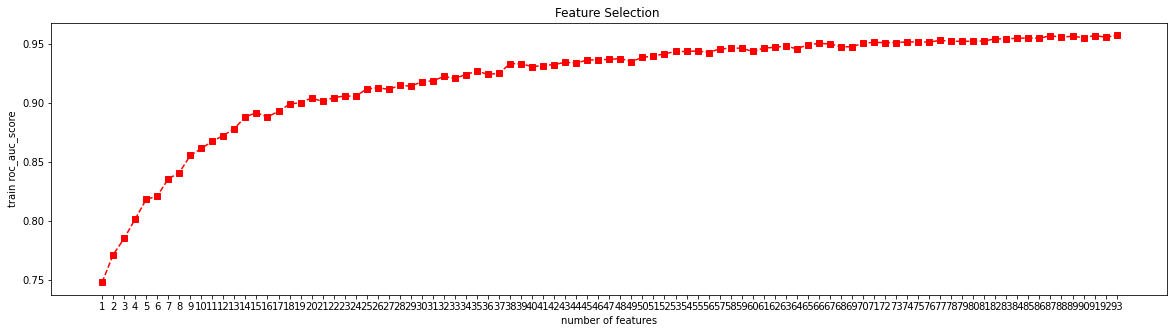

In [ ]:
min_feat = 1
features_cnt = 93
x_lim = [i for i in range(min_feat, features_cnt+1)]

plt.figure(figsize=(20,5))
plt.plot(x_lim, feature_selection_score, 'rs--')
plt.xlabel("number of features")
plt.ylabel("train roc_auc_score")
plt.title("Feature Selection ")
plt.xticks(np.arange(min(x_lim), max(x_lim)+1, 1.0))
plt.show()

In [ ]:
xgb_clf = XGBClassifier(random_state=random_seed)
xgb_clf.fit(X_train_over[:, :21], y_train_over)
pred = xgb_clf.predict(X_test[:, :21])

evaluation_report(y_test, pred)

accuracy_score = 0.81	precision_score = 0.97	recall_score = 0.82	f1_score = 0.89	roc_auc_score = 0.67	

In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

         0.0       0.13      0.51      0.20       183
         1.0       0.97      0.82      0.89      3600

    accuracy                           0.81      3783
   macro avg       0.55      0.67      0.55      3783
weighted avg       0.93      0.81      0.86      3783

